# Running the simulation

Required packages:
numpy, matplotlib, seaborn, tqdm, sklearn (scikit-learn)

In [1]:
import os
os.chdir("../")

Comment out the cell below if the simulation has already been run

In [2]:
# from src.Application import Application
# Application().run()

# Plotting overview

In [3]:
from src.plotter.directory_management import *

In [4]:
cd_general_plotting_directory()

In [5]:
import os
os.getcwd()

'/Users/thatmariia/Desktop/Internships/CCN/PING/REPOS/grid-ping/plots/SIM_PLOTS/overviews'

In [6]:
return_to_start_path_from_general()

## Plotting a single simulation

In [7]:
# choose from [1.0, 1.125, 1.25, 1.375, 1.5]
distance_scale = 1.0

# choose from [0.01, 0.0257, 0.505, 0.7525, 1]
contrast_range = 0.01

In [8]:
cd_partic_plotting_directory(distance_scale, contrast_range)

### Full stimulus

### Spikes data

In [9]:
from src.plotter.raw_data import fetch_spikes_data
from src.params.ParamsInitializer import ParamsInitializer
from src.params.NeuronTypes import NeuronTypes
from src.izhikevich_simulation.GridGeometryFactory import GridGeometryFactory
from src.izhikevich_simulation.GridGeometry import GridGeometry
from src.izhikevich_simulation.PINGNetworkNeurons import PINGNetworkNeurons
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
np.set_printoptions(threshold=sys.maxsize)

import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
PLOT_SIZE = 8

mpl.rcParams['lines.linewidth'] = PLOT_SIZE / 2
mpl.rcParams['axes.linewidth'] = PLOT_SIZE / 10
mpl.rcParams['axes.labelsize'] = 2 * PLOT_SIZE
mpl.rcParams['axes.labelpad'] = 2 * PLOT_SIZE
mpl.rcParams['axes.titlesize'] = 3 * PLOT_SIZE
mpl.rcParams['axes.titlepad'] = PLOT_SIZE#2 * PLOT_SIZE
mpl.rcParams['legend.fontsize'] = 3 * PLOT_SIZE
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Avenir'
mpl.rcParams['font.weight'] = 'ultralight'

# getting parameters
params_initializer = ParamsInitializer()
params_ping, params_gabor, params_rf, params_connectivity, params_izhi, params_synaptic, params_freqs = params_initializer.initialize(
    dist_scale=distance_scale,
    contrast_range=contrast_range
)

ping_networks = GridGeometryFactory().create(params_ping, np.zeros((params_ping.nr_neurons["total"], params_ping.nr_neurons["total"]))).ping_networks
def neuron_ids_of_network(ping_network):
    return ping_network.ids[NeuronTypes.EX] + ping_network.ids[NeuronTypes.IN]

def get_spikes(spikes, ind_start, ind_end):
    indices = np.argwhere(
        (spikes.T[1] >= ind_start) &
        (spikes.T[1] < ind_end)
    ).flatten()
    return spikes[indices]

def get_ex_spikes(spikes):
    return get_spikes(spikes, params_ping.neur_slice[NeuronTypes.EX].start, params_ping.neur_slice[NeuronTypes.EX].stop)

def get_in_spikes(spikes):
    return get_spikes(spikes, params_ping.neur_slice[NeuronTypes.IN].start, params_ping.neur_slice[NeuronTypes.IN].stop)


def apply_window(arr, window_start, window_end):
    arr_window_indices = np.argwhere(
        (arr.T[0] >= window_start) & 
        (arr.T[0] < window_end) 
    ).flatten()
    return arr[arr_window_indices]

    

def select_spikes_window(spikes, spikes_ex, spikes_in, window_start, window_end):
    spikes = apply_window(spikes, window_start, window_end)
    spikes_ex = apply_window(spikes_ex, window_start, window_end)
    spikes_in = apply_window(spikes_in, window_start, window_end)
    return spikes, spikes_ex, spikes_in

Computing distances between PING networks: 100%|█| 400/400 [00:07<00:00, 51.04it


In [10]:
import os
os.getcwd()

'/Users/thatmariia/Desktop/Internships/CCN/PING/REPOS/grid-ping/plots/SIM_PLOTS/dist-1.0000___contrast-0.0100'

In [11]:
os.chdir("../../")

In [12]:
# fetching spikes
os.chdir("../")
all_spikes = fetch_spikes_data(distance_scale, contrast_range)

# indices of excitatory spikes
all_spikes_ex = get_ex_spikes(all_spikes)

# indices of inhibitory spikes
all_spikes_in = get_in_spikes(all_spikes)

# fetching spikes per ping
ping_spikes = {}
ping_spikes_ex = {}
ping_spikes_in = {}

for ping_network in ping_networks:
    
    ping_spikes_mask = np.isin(
        all_spikes.T[1], neuron_ids_of_network(ping_network)
    )
    ping_spikes[ping_network.grid_location] = all_spikes[ping_spikes_mask]
    ping_spikes_ex[ping_network.grid_location] = get_ex_spikes(ping_spikes[ping_network.grid_location])
    ping_spikes_in[ping_network.grid_location] = get_in_spikes(ping_spikes[ping_network.grid_location])

In [ ]:
def compute_nr_spikes(spikes):
    return len(spikes)

def compute_mean_nr_spikes_per_ts(spikes, window):
    return np.mean([np.count_nonzero(spikes.T[0] == t) for t in range(window[0], window[1])])

def compute_std_nr_spikes_per_ts(spikes, window):
    return np.std([np.count_nonzero(spikes.T[0] == t) for t in range(window[0], window[1])])

def compute_nr_neurons_spiked_count(spikes, step):
    id_counter = np.array([np.count_nonzero(spikes.T[1] == i) for i in range(params_ping.nr_neurons["total"])])
    return np.array([np.count_nonzero(id_counter == i) for i in range(step)])


In [ ]:
spikes_stats = []

step = 100
windows = [(i, i + step) for i in range(0, 1000, step)]


def compute_stats(spikes, spikes_ex, spikes_in, window):
    nr_spikes = compute_nr_spikes(spikes)
    nr_spikes_ex = compute_nr_spikes(spikes_ex)
    nr_spikes_in = compute_nr_spikes(spikes_in)
    mean_nr_spikes_per_ts = compute_mean_nr_spikes_per_ts(spikes, window)
    mean_nr_spikes_ex_per_ts = compute_mean_nr_spikes_per_ts(spikes_ex, window)
    mean_nr_spikes_in_per_ts = compute_mean_nr_spikes_per_ts(spikes_in, window)
    std_nr_spikes_per_ts = compute_std_nr_spikes_per_ts(spikes, window)
    std_nr_spikes_ex_per_ts = compute_std_nr_spikes_per_ts(spikes_ex, window)
    std_nr_spikes_in_per_ts = compute_std_nr_spikes_per_ts(spikes_in, window)
    nr_neurons_spiked_count = compute_nr_neurons_spiked_count(spikes, step)
    nr_neurons_spiked_count_ex = compute_nr_neurons_spiked_count(spikes_ex, step)
    nr_neurons_spiked_count_in = compute_nr_neurons_spiked_count(spikes_in, step)
    return [
        nr_spikes, nr_spikes_ex, nr_spikes_in, 
        mean_nr_spikes_per_ts, mean_nr_spikes_ex_per_ts, mean_nr_spikes_in_per_ts,
        std_nr_spikes_per_ts, std_nr_spikes_ex_per_ts, std_nr_spikes_in_per_ts,
        nr_neurons_spiked_count, nr_neurons_spiked_count_ex, nr_neurons_spiked_count_in
    ]

cols = []
for i in range(-1, len(ping_networks)):
    imod = "" if (i == -1) else i
    new_cols = [
        f"nr_spikes{imod}", 
        f"nr_spikes_ex{imod}", 
        f"nr_spikes_in{imod}", 
        f"mean_nr_spikes_per_ts{imod}",
        f"mean_nr_spikes_ex_per_ts{imod}",
        f"mean_nr_spikes_in_per_ts{imod}",
        f"std_nr_spikes_per_ts{imod}",
        f"std_nr_spikes_ex_per_ts{imod}",
        f"std_nr_spikes_in_per_ts{imod}",
        f"nr_neurons_spiked_count{imod}",
        f"nr_neurons_spiked_count_ex{imod}",
        f"nr_neurons_spiked_count_in{imod}"
    ]
    cols = cols + new_cols

for window in windows:
    spikes, spikes_ex, spikes_in = select_spikes_window(all_spikes, all_spikes_ex, all_spikes_in, window[0], window[1])
    gen_stats = compute_stats(spikes, spikes_ex, spikes_in, window)
    
    ping_stats = []
    for ping_network in ping_networks:
        spikes, spikes_ex, spikes_in = select_spikes_window(
            ping_spikes[ping_network.grid_location],
            ping_spikes_ex[ping_network.grid_location],
            ping_spikes_in[ping_network.grid_location],
            window[0], window[1]
        )
        ping_stats = ping_stats + compute_stats(spikes, spikes_ex, spikes_in, window)

    spikes_stats.append(gen_stats + ping_stats)

spikes_df = pd.DataFrame(
    spikes_stats, 
    columns = cols,
    index = windows
)
spikes_df
    

In [ ]:
spikes_df.to_csv("df.csv", index=False)

In [ ]:
fig, ax = plt.subplots(figsize=(4 * PLOT_SIZE, PLOT_SIZE))

in_color = "#ACDDE7"
ex_color = "#FFA3AF"

ax.scatter(all_spikes_ex.T[0], all_spikes_ex.T[1], s=PLOT_SIZE/5, color=ex_color, label="EX")
#ax.scatter(all_spikes_in.T[0], all_spikes_in.T[1], s=PLOT_SIZE/5, color=in_color, label="IN")
ax.legend()
ax.set_xlabel("time ms")
ax.set_ylabel("neuron ID")
ax.set_title("Spike raster")
#ax.set_ylim(3080, 3200)

fig.savefig("raster.pdf", bbox_inches='tight', pad_inches=1)

In [ ]:
from collections import Counter
from statistics import mean

counter = Counter(all_spikes.T[1])
nr_spikes = counter.values()
nr_spikes
print(min(nr_spikes), max(nr_spikes), mean(nr_spikes))

In [ ]:
import seaborn as sns

mid_windows = [w[0] + (w[1] - w[0]) / 2 for w in windows]

fig, ax = plt.subplots(figsize=(1.2*PLOT_SIZE, 1.2*PLOT_SIZE))

heatmap = np.array([np.array(a) for a in spikes_df["nr_neurons_spiked_count"].to_numpy()]).T
top_nonzero = np.max(np.nonzero(heatmap)[0]) + 1

sns.heatmap(
    heatmap[:top_nonzero, :],
    annot=True,
    cbar=False,
    square=True,
    cmap="Blues",
    xticklabels=True,
    yticklabels=True,
    ax=ax
)
ax.set_xticklabels(mid_windows)
ax.set_xlabel("mid window time, ms")
ax.set_ylabel("spike count")
ax.set_title("Number of neurons spiked")
ax.invert_yaxis()

fig.savefig("nr_neurons.pdf", bbox_inches='tight', pad_inches=1)

In [ ]:
ntypes = 3
fig, ax = plt.subplots(nrows=ntypes, ncols=1+len(ping_networks), sharex=True, figsize=((1+len(ping_networks)) * PLOT_SIZE, ntypes * PLOT_SIZE * 0.5))
plt.subplots_adjust(top=1.5, right=1.5)

in_color = "#ACDDE7"
ex_color = "#FFA3AF"
none_color = "#FCEA88"


mid_windows = [w[0] + (w[1] - w[0]) / 2 for w in windows]
int_x = np.linspace(mid_windows[0], mid_windows[-1], num=300, endpoint = True)
def int_y(arr):
    return scipy.interpolate.make_interp_spline(mid_windows, arr)(int_x)

def plot_spikes(axis, spikes, spikes_ex, spikes_in, title="", ytitle="", ping_id=None, ping_location=None):
    axis.plot(int_x, int_y(spikes), c=none_color, label="both spikes", zorder=0)
    axis.scatter(mid_windows, spikes, s=10*PLOT_SIZE, c="black", zorder=1)
    axis.plot(int_x, int_y(spikes_ex), c=ex_color, label="spikes EX", zorder=0)
    axis.scatter(mid_windows, spikes_ex, s=10*PLOT_SIZE, c="black", zorder=1)
    axis.plot(int_x, int_y(spikes_in), c=in_color, label="spikes IN", zorder=0)
    axis.scatter(mid_windows, spikes_in, s=10*PLOT_SIZE, c="black", zorder=1)
    axis.legend(loc="center right")
    axis.set_xlabel("mid window time, ms")
    axis.set_ylabel(ytitle)
    if not ping_id and not ping_location:
        axis.set_title(title)
    else:
        axis.set_title(f"{title}; PING {ping_id} at {ping_location}")

nr_spikes_title = "Number of spikes"
nr_spikes_ytitle = f"nr of spikes in a window of {step} ms"
mean_spikes_title = "Mean number of spikes"
mean_spikes_ytitle = f"mean nr of spikes per ms in a window of {step} ms"
std_spikes_title = "STD of number of spikes"
std_spikes_ytitle = f"std of nr of spikes per ms in a window of {step} ms"

def draw_col_plots(ax_x, ping_id=None, ping_location=None):
    
    ping_id_str = "" if not ping_id else str(ping_id)
    plot_spikes(
        axis=ax[0][ax_x],
        spikes=spikes_df[f"nr_spikes{ping_id_str}"],
        spikes_ex=spikes_df[f"nr_spikes_ex{ping_id_str}"],
        spikes_in=spikes_df[f"nr_spikes_in{ping_id_str}"],
        title=nr_spikes_title,
        ytitle=nr_spikes_ytitle,
        ping_id=ping_id, 
        ping_location=ping_location
    )

    plot_spikes(
        axis=ax[1][ax_x],
        spikes=spikes_df[f"mean_nr_spikes_per_ts{ping_id_str}"],
        spikes_ex=spikes_df[f"mean_nr_spikes_ex_per_ts{ping_id_str}"],
        spikes_in=spikes_df[f"mean_nr_spikes_in_per_ts{ping_id_str}"],
        title=mean_spikes_title,
        ytitle=mean_spikes_ytitle,
        ping_id=ping_id, 
        ping_location=ping_location
    )

    plot_spikes(
        axis=ax[2][ax_x],
        spikes=spikes_df[f"std_nr_spikes_per_ts{ping_id_str}"],
        spikes_ex=spikes_df[f"std_nr_spikes_ex_per_ts{ping_id_str}"],
        spikes_in=spikes_df[f"std_nr_spikes_in_per_ts{ping_id_str}"],
        title=std_spikes_title,
        ytitle=std_spikes_ytitle,
        ping_id=ping_id, 
        ping_location=ping_location
    )
    

col_count = 0
draw_col_plots(col_count)

for ping_network in ping_networks:
    # TODO:: plot the same stuff for pings
    col_count += 1
    draw_col_plots(col_count, col_count-1, ping_network.grid_location)
    
fig.savefig("stats_per_ping.pdf", bbox_inches='tight', pad_inches=1)

In [13]:
from src.after_simulation_analysis.SyncEvaluationFactory import SyncEvaluationFactory

USE_RANDOM_VECTORS = False

if USE_RANDOM_VECTORS:

    import random 
    random_vectors = []
    p = 1.0/24
    for _ in range(1000):
        #random_vectors.append([random.randint(0, 1) for _ in range(1000)])
        random_vectors.append(np.random.binomial(n=1, p=p, size=1000))
        
    sync_eval = SyncEvaluationFactory()._compute_cross_correlation(np.array(random_vectors), 1000)
else:
    sync_eval = SyncEvaluationFactory().create(all_spikes, params_ping, 1000)
    
#phase_values, phase_locking   

max_lag = 21


Computing cross-correlation & stuff: 100%|██████| 20/20 [00:00<00:00, 61.78it/s]


In [14]:
phase_values = sync_eval.phase_values
phase_locking = sync_eval.phase_locking
phase_locking.shape

(20, 20)

<AxesSubplot:>

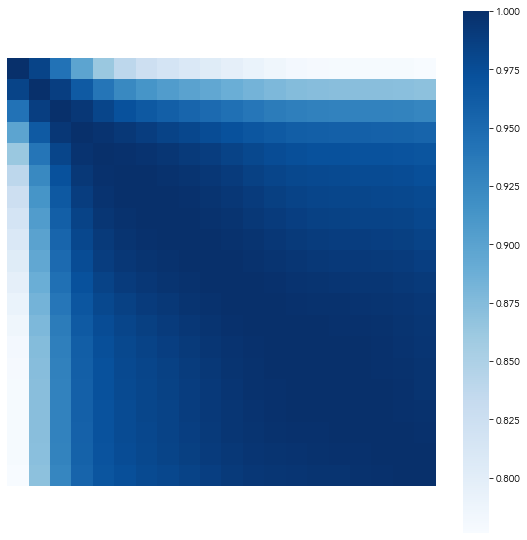

In [15]:
fig, ax = plt.subplots(figsize=(1.2*PLOT_SIZE, 1.2*PLOT_SIZE))

import seaborn as sns

sns.heatmap(
    phase_locking,
    annot=False,
    cbar=True,
    square=True,
    cmap="Blues",
    vmin=0,
    vmax=1,
    xticklabels=False,
    yticklabels=False,
    ax=ax
)

# fig.savefig("phase_locking.pdf", bbox_inches='tight', pad_inches=1)

In [16]:
# print(min(phase_values.flatten()), max(phase_values.flatten()), np.mean(phase_values.flatten()))
print(min(phase_locking.flatten()), max(phase_locking.flatten()), np.mean(phase_locking.flatten()))

print(
    np.mean([phase_locking[i][j] for i in range(phase_locking.shape[0]) for j in range(phase_locking.shape[1]) if i != j])
)

0.7763346620136423 1.0 0.9615884679633048
0.9595668083824261


In [17]:
from src.plotter.raw_data import fetch_cortical_dist_data

distances = fetch_cortical_dist_data()
distances

TypeError: fetch_cortical_dist_data() missing 2 required positional arguments: 'dist_scale' and 'contrast_range'

In [18]:
step_size = 10

dist_pl = {}

for i in range(phase_locking.shape[0]):
    for j in range(phase_locking.shape[1]):
        pl = phase_locking[i][j]
        id_i = step_size * i
        id_j = step_size * j
        ping_i = id_i // params_ping.nr_neurons_per_ping[NeuronTypes.IN]
        ping_j = id_j // params_ping.nr_neurons_per_ping[NeuronTypes.IN]
        dist = distances[ping_i][ping_j]
        if dist not in dist_pl:
            dist_pl[dist] = []
        dist_pl[dist].append(pl)

x = []
y = []

for dist in sorted(dist_pl.keys()):
    x.append(dist)
    y.append(np.mean(dist_pl[dist]))

fig, ax = plt.subplots(figsize=(10, 10))  

ax.scatter(x, y, s=100, c=in_color)
ax.set_xlabel("interneuron distance")
ax.set_ylabel("average phase-locking")
fig.savefig("avg_phase_locking.pdf", bbox_inches='tight', pad_inches=1)


NameError: name 'distances' is not defined

In [ ]:
# return_to_start_path_from_partic()

In [ ]:
import pandas as pd
import numpy as np
import scipy.interpolate
from itertools import product

indices = ["1", "2", "3", "4"]
columns = ["3", "4", "5", "6"]
empty_df = pd.DataFrame(index=indices, columns=columns, dtype=float)

for i, c in product(indices, columns):
    empty_df.at[i, c] = 1

arr = empty_df.to_numpy()

interpolation_len = 10

contrast_ranges = [float(i) for i in empty_df.columns.tolist()]
dist_scales = [float(i) for i in empty_df.index.tolist()]

contrast_ranges_interpolated = np.linspace(contrast_ranges[0], contrast_ranges[-1], num=interpolation_len)
dist_scales_interpolated = np.linspace(dist_scales[0], dist_scales[-1], num=interpolation_len)

interpolation = scipy.interpolate.RectBivariateSpline(contrast_ranges, dist_scales, arr)

arr_interpolated = interpolation(contrast_ranges_interpolated, dist_scales_interpolated)
arr_interpolated

#scipy.interpolate.make_interp_spline(mid_windows, arr)(int_x)

# fig, ax = plt.subplots(figsize=(PLOT_SIZE, PLOT_SIZE))
# sns.heatmap(
#     empty_df,
#     annot=True,
#     square=True,
#     ax=ax
# )

In [ ]:
simulation_time = 1000

def get_type_raster(spikes_type, params_ping, neur_type, simulation_time):

    raster = np.zeros((params_ping.nr_neurons[neur_type], simulation_time))

    for neur_id in range(params_ping.neur_slice[neur_type].start, params_ping.neur_slice[neur_type].stop):
        # find indices of spikes of a neuron with id neur_id
        spikes_indices = np.argwhere(
            (spikes_type.T[1] == neur_id)
        ).flatten()
        # assign 1 to the indices of the raster
        raster[neur_id - params_ping.neur_slice[neur_type].start, spikes_type.T[0].astype(int)[spikes_indices]] = 1

    return raster

spikes_T = all_spikes.T

# indices when neurons fired
spikes_in_indices = np.argwhere(
    (spikes_T[1] >= params_ping.neur_slice[NeuronTypes.IN].start) &
    (spikes_T[1] < params_ping.neur_slice[NeuronTypes.IN].stop)
).flatten()
spikes_ex_indices = np.argwhere(
    (spikes_T[1] >= params_ping.neur_slice[NeuronTypes.EX].start) &
    (spikes_T[1] < params_ping.neur_slice[NeuronTypes.EX].stop)
).flatten()
# times when neurons fired
spikes_in = np.array(list(zip(spikes_T[0][spikes_in_indices], spikes_T[1][spikes_in_indices])))
spikes_ex = np.array(list(zip(spikes_T[0][spikes_ex_indices], spikes_T[1][spikes_ex_indices])))

raster_ex = get_type_raster(
    spikes_type=spikes_ex,
    params_ping=params_ping,
    neur_type=NeuronTypes.EX,
    simulation_time=simulation_time
)
raster_in = get_type_raster(
    spikes_type=spikes_in,
    params_ping=params_ping,
    neur_type=NeuronTypes.IN,
    simulation_time=simulation_time
)

In [ ]:
crop_start = 950
crop_end = 999
#crop_neur_id = 1
for crop_neur_id in range(0, 1000):
    crop_raster_ex = raster_ex[crop_neur_id][crop_start:crop_end]
    if sum(crop_raster_ex) > 1:
        print(sum(crop_raster_ex))
        print(crop_neur_id)
        print()
#print(crop_raster_ex)


In [ ]:
1/80